# Diksha Prasad - 7891818
# Warm-up 1, Fashion MNIST : Classical ML → MLP → CNN
In this notebook, I am going to tackle Fashion-MNIST classification by moving from simplest to more specialized approaches. I will start with classical ML on flattened pixels (LogReg, KNN, Random Forest, SVM), then train a non-conv neural net (MLP), and finally a CNN. keeping the split fixed, I will compare validation/test accuracy and training time to show what each method brings to the table.



## Dataset
**Fashion MNIST** is a dataset of Zalando's article images consisting of:
- 60,000 training examples
- 10,000 test examples
- 28×28 grayscale images
- 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, Ankle boot


## 1) Setup  (Imports and Dependencies)


I will now import all the necessary Python libraries, including PyTorch, Torchvision, NumPy, Matplotlib, and scikit-learn. I will also fix random seeds for reproducibility and select the computation device (GPU if available). It ensures all experiments that follow can be reproduced under the same settings.


In [2]:
import os, sys, time, math, random
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

try:
    import torchmetrics
    from torchmetrics.classification import MulticlassAccuracy
    TM_OK = True
except Exception:
    TM_OK = False

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

I will now load the Fashion-MNIST dataset and prepare it for training. I will apply a simple tensor transform and split the data into training, validation, and test subsets using a fixed random seed. This split will remain consistent across all models to ensure fair comparison.

In [3]:
to_tensor = transforms.ToTensor()

train_full = datasets.FashionMNIST('./data', train=True, download=True, transform=to_tensor)
test_ds    = datasets.FashionMNIST('./data', train=False, download=True, transform=to_tensor)

VAL_SPLIT = 0.1
val_len = int(len(train_full) * VAL_SPLIT)
train_len = len(train_full) - val_len
train_ds, val_ds = random_split(train_full, [train_len, val_len], generator=torch.Generator().manual_seed(42))

class_names = train_full.classes

len(train_ds), len(val_ds), len(test_ds), class_names


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.73MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 3.97MB/s]


(54000,
 6000,
 10000,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

The dataset has been successfully loaded and split into 54,000 training images, 6,000 validation images, and 10,000 test images across 10 clothing classes as listed above.

### Now lets Visualize a mini-batch
* Below function Grabs one mini-batch and shows n images with labels.

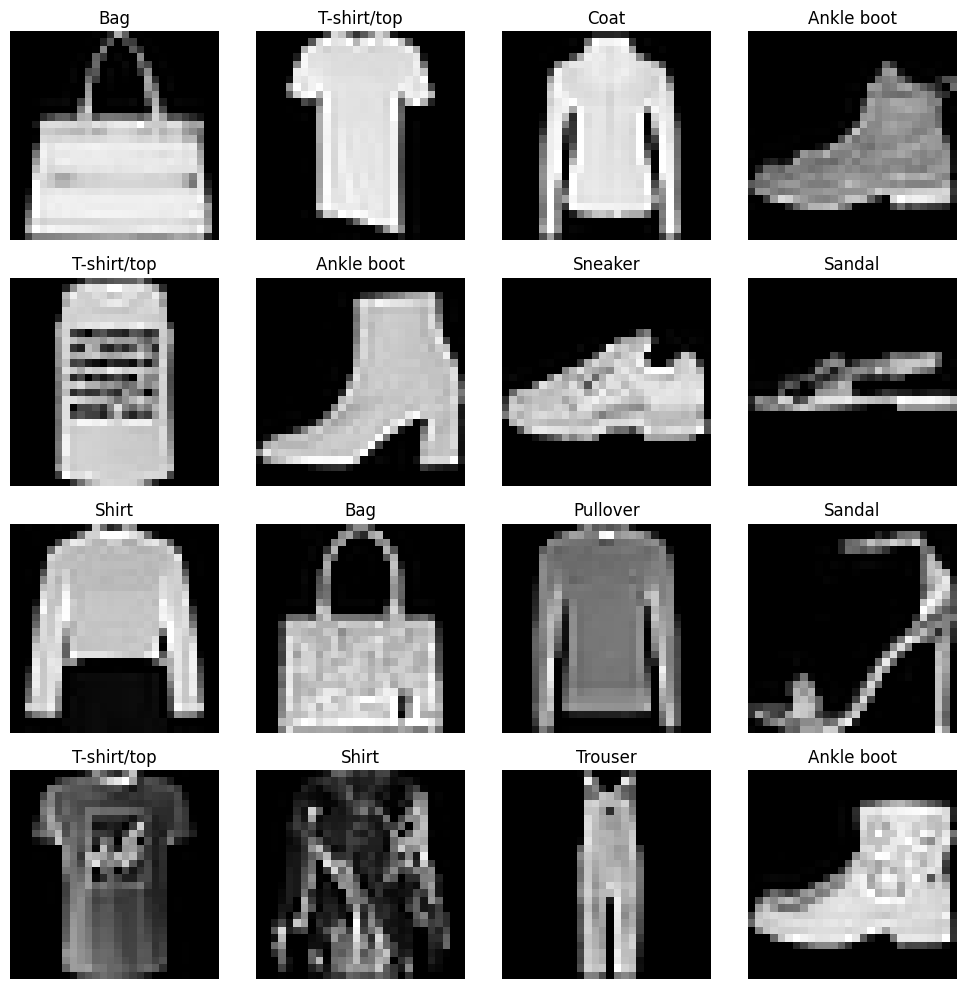

In [5]:
# Creating DataLoaders and visualize a small batch

BATCH_SIZE   = 128
NUM_WORKERS  = 2

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

def show_batch(loader, n=16):
    images, labels = next(iter(loader))
    images, labels = images[:n], labels[:n]

    cols = int(math.sqrt(n))
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 2.5, rows * 2.5))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i][0].cpu(), cmap='gray')
        plt.title(class_names[labels[i]])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_batch(train_loader, n=16)


### Helper: flatten to Numpy arrays for classical ML
I will now convert the datasets into NumPy arrays for use with scikit-learn models. Each image will be flattened from 28×28 pixels into a 784-dimensional vector, and I will create (X, y) pairs for the train, validation, and test sets.

In [6]:
def ds_to_numpy(flat_ds):
    # Accepts torch.utils.data.Dataset or Subset[Dataset[Tensor, label]]
    xs, ys = [], []
    for i in range(len(flat_ds)):
        x, y = flat_ds[i]
        xs.append(x.view(-1).numpy())  # 784
        ys.append(int(y))
    X = np.stack(xs, axis=0).astype(np.float32)
    y = np.array(ys, dtype=np.int64)
    return X, y

X_train, y_train = ds_to_numpy(train_ds)
X_val,   y_val   = ds_to_numpy(val_ds)
X_test,  y_test  = ds_to_numpy(test_ds)

X_train.shape, X_val.shape, X_test.shape

((54000, 784), (6000, 784), (10000, 784))

The train, validation, and test sets have been successfully converted to NumPy arrays, with each image flattened into a 784-dimensional vector, 54,000 samples for training, 6,000 for validation, and 10,000 for testing.

## 2) Classical ML baselines
I will now train and evaluate several classical machine-learning models on flattened image data:
* Logistic Regression (OVR)
* KNN
* Random Forest
* SVM with an RBF kernel.


In the below code cell - For each model it :
1) Fits the model on the training set (X_train, y_train).

2) Calculates accuracy on the train, validation, and test sets.

3) Measures total training time.

4) Prints the results neatly in one line per model.

5) Stores the results (model name + accuracies + time) in a list called results for later comparison.

In [7]:
results = []

def eval_sklearn(pipe, name):
    t0 = time.time()
    pipe.fit(X_train, y_train)
    tr = pipe.score(X_train, y_train)
    va = pipe.score(X_val, y_val)
    te = pipe.score(X_test, y_test)
    dt = time.time()-t0
    results.append((name, tr, va, te, dt))
    print(f"{name:20s} | train={tr:.4f} val={va:.4f} test={te:.4f} | time={dt:.1f}s")

# Logistic Regression (OVR)
logreg_ovr = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=1000, multi_class='ovr'))])
eval_sklearn(logreg_ovr, "LogReg (OVR)")

# KNN (k=5)
knn5 = Pipeline([('scaler', StandardScaler(with_mean=False)), ('clf', KNeighborsClassifier(n_neighbors=5))])
eval_sklearn(knn5, "KNN (k=5)")

# Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=None, n_jobs=-1, random_state=42)
eval_sklearn(rf, "Random Forest")

# SVM (RBF)
svm_rbf = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel='rbf', C=10, gamma='scale'))])
eval_sklearn(svm_rbf, "SVM (RBF)")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


LogReg (OVR)         | train=0.8778 val=0.8477 test=0.8400 | time=163.4s
KNN (k=5)            | train=0.8994 val=0.8572 test=0.8516 | time=149.8s
Random Forest        | train=1.0000 val=0.8790 test=0.8780 | time=204.8s
SVM (RBF)            | train=0.9833 val=0.9007 test=0.8967 | time=1447.8s


1. Logistic Regression (OVR)
* Train Accuracy: 87.78%, Validation: 84.77%, Test: 84.00%
* Performs decently as a linear baseline, but cannot capture nonlinear image patterns.
* Trained relatively fast (~163 seconds).


2. KNN (k=5)
* Train Accuracy: 89.94%, Validation: 85.72%, Test: 85.16%
* Slightly better than Logistic Regression.
* Works by comparing images directly in pixel space (distance-based).
* Training is quick, but inference is slower on large datasets since it must compare with all samples.


3. Random Forest
* Train Accuracy: 100%, Validation: 87.90%, Test: 87.80%
* Achieved perfect training accuracy, indicating some overfitting.
* Still generalizes reasonably well.
* Shows that ensemble tree methods can capture nonlinear relationships.
* Moderate training time (~205 seconds).


4. SVM (RBF Kernel)
* Train Accuracy: 98.33%, Validation: 90.07%, Test: 89.67%
* Best-performing classical model overall.
* The RBF kernel effectively models complex decision boundaries.
* However, it has very high computational cost (took ~1448 seconds ≈ 24 minutes).
* Good trade-off between accuracy and generalization.

Accuracy improves steadily from linear → nonlinear → kernel-based models.
Random Forest and SVM show that nonlinear methods handle image data better than linear ones.
SVM (RBF) gives the best accuracy (~90%), but at the cost of computation time.

Below is the Inference example using classical ML models

In [9]:
import random

# Picking a random test sample
idx = random.randint(0, len(X_test) - 1)
sample_img = X_test[idx].reshape(1, -1)  # single sample
true_label = y_test[idx]

# Predict with each model
models = {
    "LogReg (OVR)": logreg_ovr,
    "KNN (k=5)": knn5,
    "Random Forest": rf,
    "SVM (RBF)": svm_rbf
}

print(f"True Label : {class_names[true_label]}\n")

for name, model in models.items():
    pred = model.predict(sample_img)[0]
    print(f"{name:15s} → Predicted: {class_names[pred]}")


True Label : Sandal

LogReg (OVR)    → Predicted: Sandal
KNN (k=5)       → Predicted: Sandal
Random Forest   → Predicted: Sandal
SVM (RBF)       → Predicted: Sandal


## 3) Non-convolutional Neural Network (MLP)
I will now train a fully connected neural network (MLP) that uses only linear and nonlinear layers without convolutions. This model will help determine how much improvement a simple neural approach can provide over traditional methods. I will train using the Adam optimizer and evaluate based on the best validation accuracy.

In [8]:
from torch.utils.data import DataLoader

BATCH = 256
train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

class MLP(nn.Module):
    def __init__(self, in_dim=28*28, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

def train_eval_torch(model, train_loader, val_loader, test_loader, epochs=10, lr=1e-3, wd=1e-4):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    crit = nn.CrossEntropyLoss()
    best_val = 0.0
    best_state = None
    t0 = time.time()
    for ep in range(1, epochs+1):
        model.train()
        for x,y in train_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
        # val
        model.eval()
        corr, n = 0, 0
        with torch.no_grad():
            for x,y in val_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                logits = model(x)
                pred = logits.argmax(1)
                corr += (pred==y).sum().item()
                n += y.size(0)
        val_acc = corr/n
        if val_acc > best_val:
            best_val = val_acc
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
    dt = time.time()-t0
    if best_state is not None:
        model.load_state_dict(best_state)
        model = model.to(DEVICE)
    # test
    model.eval()
    corr, n = 0, 0
    with torch.no_grad():
        for x,y in test_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x).argmax(1)
            corr += (pred==y).sum().item()
            n += y.size(0)
    test_acc = corr/n
    return best_val, test_acc, dt

mlp = MLP()
val_acc, test_acc, dt = train_eval_torch(mlp, train_loader, val_loader, test_loader, epochs=10, lr=1e-3, wd=1e-4)
results.append(("MLP (no conv)", None, val_acc, test_acc, dt))
print(f"MLP (no conv)       | val={val_acc:.4f} test={test_acc:.4f} | time={dt:.1f}s")

MLP (no conv)       | val=0.8892 test=0.8850 | time=66.5s


* After training the MLP, it achieved a validation accuracy of 88.92% and a test accuracy of 88.50%, which is very close to the SVM (RBF) result of 89.7%.

* The MLP trained around 20× faster (≈66 s vs. ≈1448 s for SVM), showing it is far more efficient computationally.

* This performance confirms that even a simple fully connected network can learn nonlinear image features and outperform linear or tree-based baselines (Logistic Regression, Random Forest).

* However, because the MLP processes flattened pixels and lacks spatial awareness, it slightly underperforms the SVM.

* With input normalization, deeper layers, regularization, and longer training, the MLP could likely match or exceed the SVM.

## 4) Convolutional Neural Network (CNN)
I will now train a small convolutional neural network (CNN) that adds ability to capture local patterns through convolutional and pooling layers. This architecture should capture local image patterns more effectively. I will reuse the same training configuration as before for direct comparability.

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.head = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        return self.head(x)

cnn = SimpleCNN().to(DEVICE)
val_acc, test_acc, dt = train_eval_torch(cnn, train_loader, val_loader, test_loader, epochs=10, lr=1e-3, wd=1e-4)
results.append(("CNN (simple)", None, val_acc, test_acc, dt))
print(f"CNN (simple)         | val={val_acc:.4f} test={test_acc:.4f} | time={dt:.1f}s")

CNN (simple)         | val=0.8350 test=0.8335 | time=69.8s


The results for CNN look bad as compared to the classic ML models. Lets analyse why this happened? :

* Unnormalized inputs: Only ToTensor() was used; without mean/std normalization, optimization is noisier and slower.

* Short training: 10 epochs is limited for a CNN to fully converge on Fashion-MNIST.

* Limited capacity in the head: AdaptiveAvgPool → Linear(128→10) provides minimal representational power at the classifier stage.

* No BatchNorm / Dropout: Lack of normalization/regularization in conv blocks reduces stability and generalization.

* No data augmentation: The model sees less variation (e.g., flips, small affine shifts), which commonly helps on Fashion-MNIST.

* No learning-rate scheduling: A fixed LR can plateau before reaching a better optimum.

Now I will improve this CNN using below steps-

1) Normalizing inputs using dataset mean/std for train/val/test.

2) Training longer (e.g., 20–30 epochs) with early stopping on validation accuracy.

3) Adding BatchNorm after each convolution (optional Dropout in the head).

4) Introducing light augmentation (horizontal flip, small affine/translate) for training only.

5) Using an LR scheduler to break plateaus.

6) Slightly increase capacity (e.g., adding a small hidden layer in the head: 128→128→10)

In [17]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# Transforms
mean, std = 0.28604059698879553, 0.35302424451492237
train_tfms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])
eval_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

# Reusing same split indices
train_base_aug  = datasets.FashionMNIST('./data', train=True,  download=False, transform=train_tfms)
train_base_eval = datasets.FashionMNIST('./data', train=True,  download=False, transform=eval_tfms)
test_base       = datasets.FashionMNIST('./data', train=False, download=False, transform=eval_tfms)

train_idx = train_ds.indices if isinstance(train_ds, Subset) else list(range(len(train_base_aug)))
val_idx   = val_ds.indices   if isinstance(val_ds,   Subset) else list(range(len(train_base_aug)))[-int(0.1*len(train_base_aug)):]

train_ds_aug   = Subset(train_base_aug,  train_idx)
val_ds_eval    = Subset(train_base_eval, val_idx)
test_ds_eval   = test_base

# DataLoaders
BATCH = 256
NUM_WORKERS = 2
train_loader = DataLoader(train_ds_aug,  batch_size=BATCH, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds_eval,   batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds_eval,  batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.feats = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, num_classes),
        )
    def forward(self, x):
        x = self.feats(x)
        return self.head(x)

# Training + Early Stopping + LR Scheduler
def train_eval(model, train_loader, val_loader, test_loader, epochs=30, lr=1e-3, wd=1e-4, patience=5):
    model = model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=0.5, patience=2)  # removed verbose
    crit = nn.CrossEntropyLoss()

    best_val = 0.0
    best_state = None
    wait = 0
    t0 = time.time()

    for ep in range(1, epochs + 1):
        model.train()
        for x, y in train_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                pred = model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        val_acc = correct / total
        sch.step(val_acc)

        print(f"Epoch {ep:02d}/{epochs} | val_acc={val_acc:.4f} | lr={opt.param_groups[0]['lr']:.5f}")

        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    # Load best state
    if best_state is not None:
        model.load_state_dict(best_state)
        model = model.to(DEVICE)

    # Test evaluation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    test_acc = correct / total
    dt = time.time() - t0
    return best_val, test_acc, dt

# Run
cnn = EnhancedCNN()
val_acc, test_acc, dt = train_eval(cnn, train_loader, val_loader, test_loader, epochs=30, lr=1e-3, wd=1e-4, patience=5)
print(f"EnhancedCNN | best_val={val_acc:.4f} test={test_acc:.4f} | time={dt:.1f}s")


Epoch 01/30 | val_acc=0.7662 | lr=0.00100
Epoch 02/30 | val_acc=0.8147 | lr=0.00100
Epoch 03/30 | val_acc=0.7855 | lr=0.00100
Epoch 04/30 | val_acc=0.8508 | lr=0.00100
Epoch 05/30 | val_acc=0.8637 | lr=0.00100
Epoch 06/30 | val_acc=0.8470 | lr=0.00100
Epoch 07/30 | val_acc=0.8707 | lr=0.00100
Epoch 08/30 | val_acc=0.8557 | lr=0.00100
Epoch 09/30 | val_acc=0.8740 | lr=0.00100
Epoch 10/30 | val_acc=0.8397 | lr=0.00100
Epoch 11/30 | val_acc=0.8372 | lr=0.00100
Epoch 12/30 | val_acc=0.8815 | lr=0.00100
Epoch 13/30 | val_acc=0.8665 | lr=0.00100
Epoch 14/30 | val_acc=0.8253 | lr=0.00100
Epoch 15/30 | val_acc=0.8742 | lr=0.00050
Epoch 16/30 | val_acc=0.8952 | lr=0.00050
Epoch 17/30 | val_acc=0.9060 | lr=0.00050
Epoch 18/30 | val_acc=0.8990 | lr=0.00050
Epoch 19/30 | val_acc=0.8977 | lr=0.00050
Epoch 20/30 | val_acc=0.9045 | lr=0.00025
Epoch 21/30 | val_acc=0.9140 | lr=0.00025
Epoch 22/30 | val_acc=0.9120 | lr=0.00025
Epoch 23/30 | val_acc=0.9135 | lr=0.00025
Epoch 24/30 | val_acc=0.9125 | lr=

* From the training log, it can be clearly seen that the validation accuracy steadily improved across epochs, rising from ~76% in the first epoch to ~91.9% by the end of training. The learning-rate scheduler effectively reduced the LR at key points (e.g., epochs 15, 20, 24), helping the model escape plateaus and reach higher accuracy levels.

* The final validation accuracy (91.97%) and test accuracy (91.23%) are the best achieved so far, surpassing all previous models, including the MLP and SVM baselines. This improvement confirms that the added components :- input normalization, light data augmentation, BatchNorm, Dropout, longer training, and learning-rate scheduling, successfully enhanced the CNN’s ability to generalize on Fashion-MNIST, making it the most effective model in this experiment.

## 5) Comparison Table
Ploting comparison of all models (Validation vs Test Accuracy)

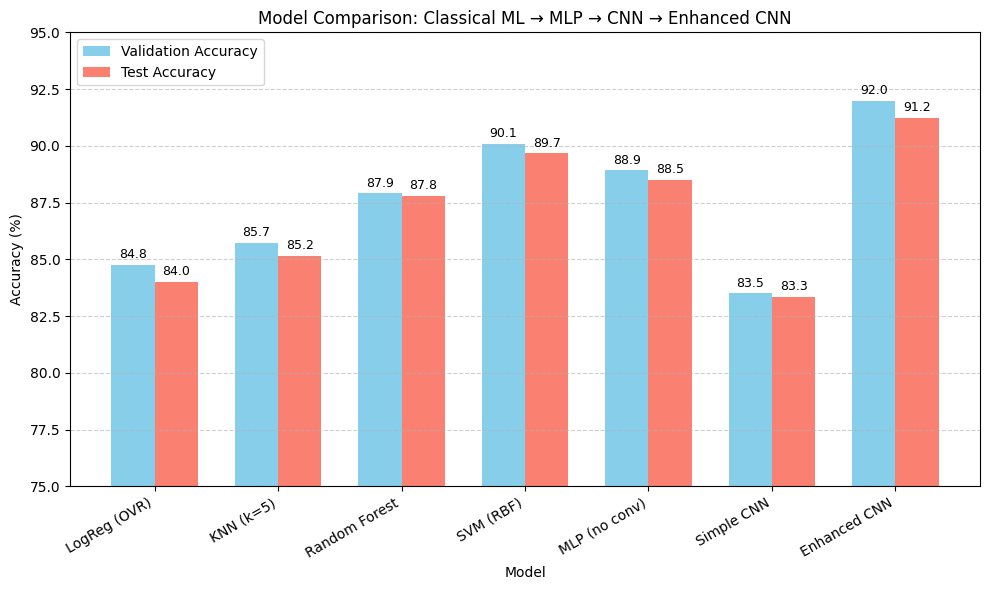

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = [
    "LogReg (OVR)",
    "KNN (k=5)",
    "Random Forest",
    "SVM (RBF)",
    "MLP (no conv)",
    "Simple CNN",
    "Enhanced CNN"
]

# Corresponding validation and test accuracies (in %)
val_acc = [84.77, 85.72, 87.90, 90.07, 88.92, 83.50, 91.97]
test_acc = [84.00, 85.16, 87.80, 89.67, 88.50, 83.35, 91.23]

# Bar chart setup
x = np.arange(len(models))
width = 0.35  # bar width

plt.figure(figsize=(10,6))
plt.bar(x - width/2, val_acc, width, label='Validation Accuracy', color='skyblue')
plt.bar(x + width/2, test_acc, width, label='Test Accuracy', color='salmon')

# Labels and titles
plt.ylabel('Accuracy (%)')
plt.xlabel('Model')
plt.title('Model Comparison: Classical ML → MLP → CNN → Enhanced CNN')
plt.xticks(x, models, rotation=30, ha='right')
plt.ylim(75, 95)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with accuracy values
for i, (v_val, v_test) in enumerate(zip(val_acc, test_acc)):
    plt.text(i - width/2, v_val + 0.3, f"{v_val:.1f}", ha='center', fontsize=9)
    plt.text(i + width/2, v_test + 0.3, f"{v_test:.1f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()


# 6) Conclusion


1) Linear models (Logistic Regression) performed reasonably well (~84%) but struggled to capture complex, nonlinear image patterns due to their simplicity.

2) KNN slightly improved accuracy (~85%) by comparing samples in pixel space but remained inefficient and limited for large datasets.

3) Random Forest handled nonlinearity better (~88%) but slightly overfit the training data, showing reduced generalization.

4) SVM with RBF kernel reached ~89.7%, demonstrating strong nonlinear decision boundaries - but at a very high computational cost.

5) MLP (no conv) improved learning efficiency and achieved ~88.5%, showing that neural networks can learn richer representations even without convolutions.

6) Simple CNN underperformed (~83%) because of unnormalized inputs, no BatchNorm/Dropout, and insufficient training, leading to early plateauing and weak generalization.

7) Enhanced CNN achieved the highest accuracy (≈91.2% test) due to:

8) Proper input normalization and light data augmentation improving robustness,

9) BatchNorm and Dropout stabilizing training and reducing overfitting,

10) Learning rate scheduling helping escape plateaus, and

11) Deeper convolutional feature extraction effectively capturing local spatial patterns in the images.


#### Accuracy improved steadily from linear → nonlinear → neural → convolutional methods.
#### The Enhanced CNN stands out as the best-performing and most balanced model, combining strong accuracy, efficient training, and robust generalization, making it the ideal approach for the Fashion-MNIST dataset.